# Music2Latent tests

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/music2latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [15]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies
        !git clone https://github.com/inspektral/music2latent.git

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils

In [17]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")

Available tests:
0: square_slow
1: square_fast
2: square_vibrato
3: saw_noise
4: sines_noise
5: filter_saw
6: triangle_clip
7: fm_amplitude
8: fm_frequency
9: delay_noise
10: delay_saw
11: reverb_noise
12: reverb_saw


In [18]:
SAMPLE_RATE = 44100
CURRENT_TEST = 0
SMALL = False

Running test: square_slow


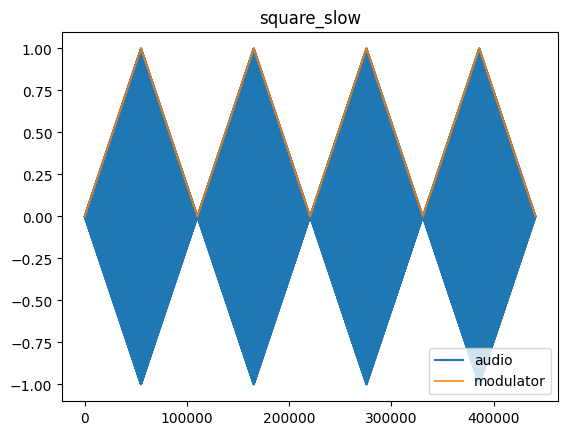

In [19]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
test_name = test.__name__
audio, modulator = test()

plt.plot(audio, label='audio')
modulator = utils.norm(synth.stretch_array(modulator, len(audio)))
plt.plot(modulator, alpha=0.8, label='modulator')
plt.title(test.__name__)
plt.legend()

plt.show()

display(Audio(audio, rate=SAMPLE_RATE)) 

In [33]:
representations = utils.get_representations(audio)

Computing mfcc representation...
Computing cqt representation...
Computing spectrum representation...
Computing music2latent representation...
Computing dac representation...


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [34]:
print(representations.keys())

dict_keys(['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'])


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create checkboxes for all available representations
available_reps = list(representations.keys())
checkbox_widgets = {rep: widgets.Checkbox(
    value=rep in ['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'],
    description=rep,
    disabled=False
) for rep in available_reps}

# Create output widget to display results
output = widgets.Output()

def update_representations(change):
    with output:
        output.clear_output()
        to_keep = [rep for rep, checkbox in checkbox_widgets.items() if checkbox.value]
        global filtered_repr
        filtered_repr = {k: v for k, v in representations.items() if k in to_keep}
        print(f"Filtered representations: {list(filtered_repr.keys())}")

# Create a button to apply changes
apply_button = widgets.Button(description="Apply Selection")
apply_button.on_click(lambda b: update_representations(None))

# Layout the widgets
vbox_checkboxes = widgets.VBox([checkbox_widgets[rep] for rep in available_reps])
widget_box = widgets.VBox([
    widgets.Label("Select representations to keep:"), 
    vbox_checkboxes, 
    apply_button, 
    output
])

# Display the widget
display(widget_box)

# Initial filtering
to_keep = [rep for rep, checkbox in checkbox_widgets.items() if checkbox.value]
filtered_repr = {k: v for k, v in representations.items() if k in to_keep}

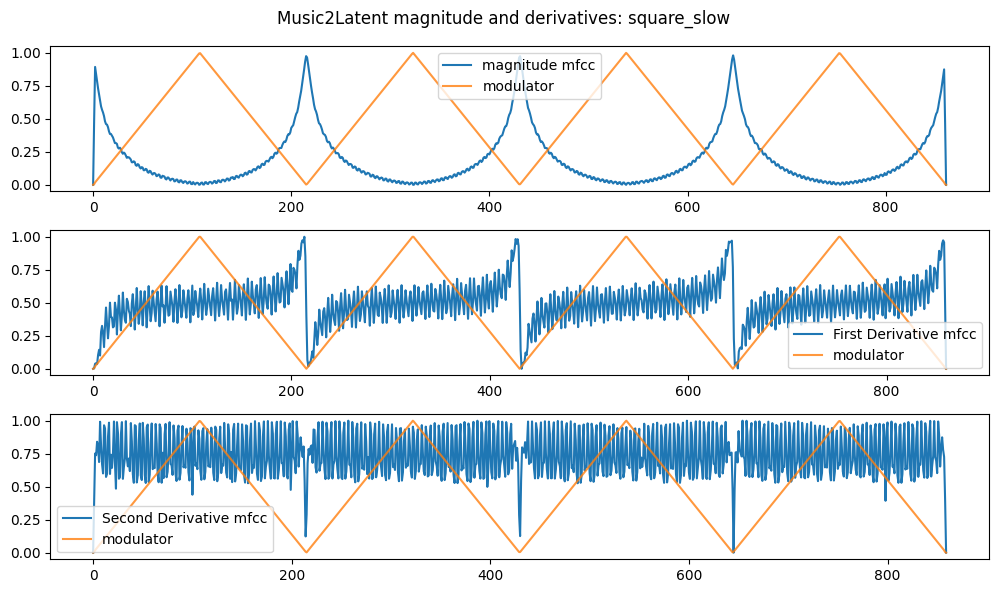

In [52]:
magnitude, d_magnitude, dd_magnitude = utils.calculate_metric(filtered_repr, np.linalg.norm, {"axis": 0})


utils.plot_with_derivatives(
    magnitude,
    d_magnitude,
    dd_magnitude,
    modulator,
    label="magnitude",
    title="Music2Latent magnitude and derivatives: "+test_name,
    small=SMALL
)

distances shape: (20, 861)


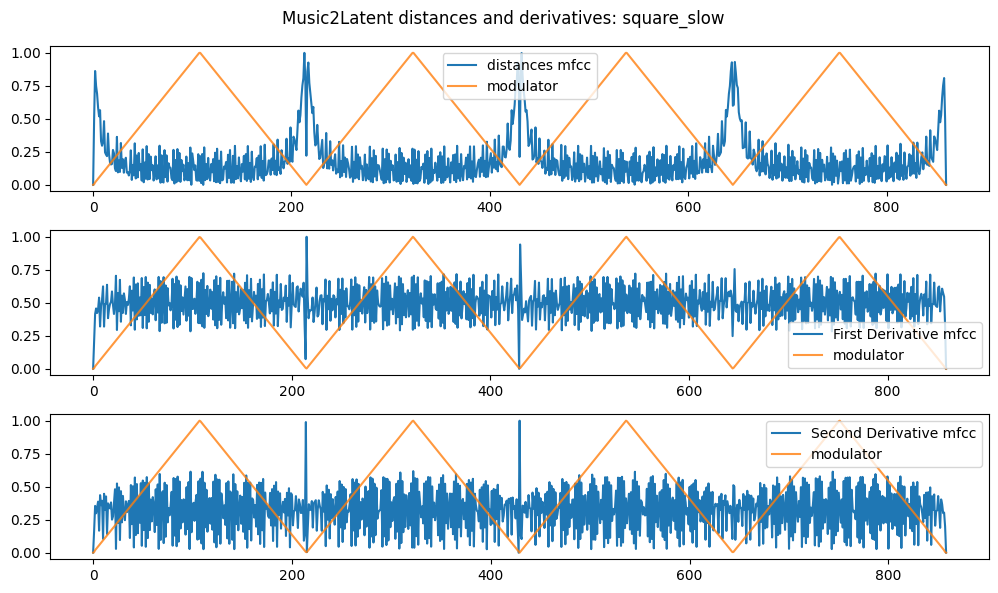

In [53]:
distances, d_distances, dd_distances = utils.calculate_metric(filtered_repr, utils.distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    modulator,
    label="distances",
    title="Music2Latent distances and derivatives: "+test_name,
    small=SMALL
)


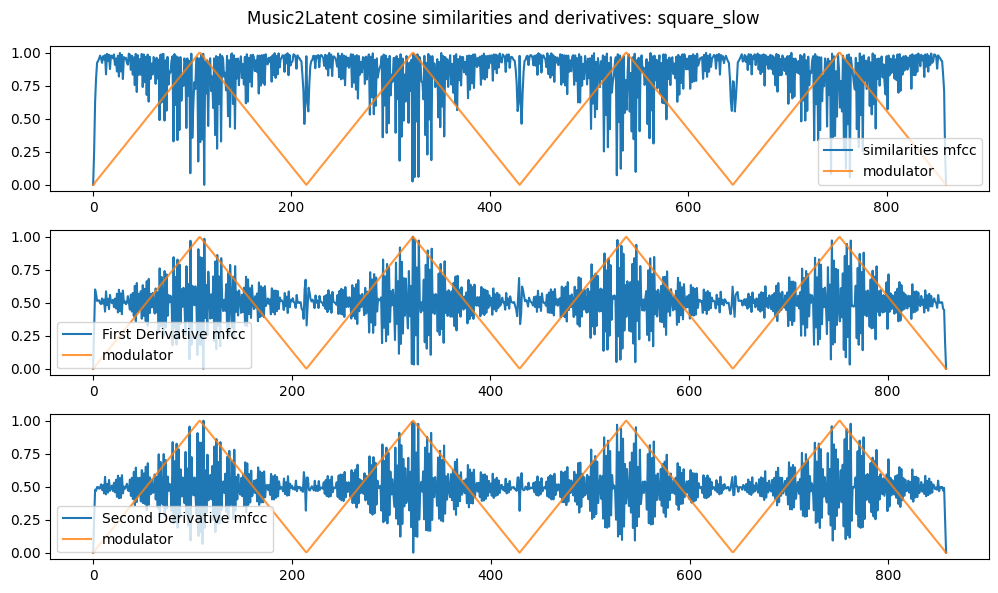

In [54]:
similarities, d_similarities, dd_similarities = utils.calculate_metric(filtered_repr, utils.cosine_similarity)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    modulator,
    label="similarities",
    title="Music2Latent cosine similarities and derivatives: "+test_name,
    small=SMALL
)